## Perform SMOTE and Test the Results with Hyperparameter Tuning

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE




In [33]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

## Add the Medication Data to the protein data

In [34]:
clin_data = pd.read_csv('../data/raw/train_clinical_data.csv')
clin_data['upd23b_clinical_state_on_medication'] = clin_data['upd23b_clinical_state_on_medication'].fillna('Unknown')

# get dummies for on_medication column
clin_data_dummies = pd.get_dummies(clin_data, columns=['upd23b_clinical_state_on_medication'], drop_first=True)

clin_data_dummies = clin_data_dummies[['visit_id', 'upd23b_clinical_state_on_medication_On', 'upd23b_clinical_state_on_medication_Unknown']]

# merge the updrs data with the clinical data for dummy columns
updrs1_df = pd.merge(updrs1_df, clin_data_dummies, on='visit_id')
updrs2_df = pd.merge(updrs2_df, clin_data_dummies, on='visit_id')
updrs3_df = pd.merge(updrs3_df, clin_data_dummies, on='visit_id')


In [35]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

In [36]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

In [37]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

In [38]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [39]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [40]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat', 'upd23b_clinical_state_on_medication_On',
       'upd23b_clinical_state_on_medication_Unknown'],
      dtype='object', length=1206)

In [41]:
## create smote function
def smote_data(df, target):
    """
    Function to perform SMOTE on a dataframe with a target variable
    """
    # separate the target variable from the dataframe
    X = df.drop(columns=target)
    y = df[target]
    
    # perform smote on the data
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    
    # create a dataframe from the smote data
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    y_smote_df = pd.DataFrame(y_smote, columns=[target])
    
    # combine the X and y smote dataframes
    smote_df = pd.concat([X_smote_df, y_smote_df], axis=1)
    
    return smote_df

In [42]:
updrs1_df_smote = smote_data(updrs1_df[updrs1_df['kfold']!=0], 'updrs_1_cat')

In [43]:
updrs1_df_smote['updrs_1_cat'].value_counts()

1    683
0    683
Name: updrs_1_cat, dtype: int64

In [44]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(1, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(1, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(1, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(1, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(1, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [45]:
def prepare_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    
    return model

In [46]:
def prepare_lgboost_model(lgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = lgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    updrs_hp['random_state'] = 42
    
    model = LGBMClassifier(**updrs_hp)
    
    return model

In [47]:
def prepare_catboost_model(cboost_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = cboost_hyperparams_df[target].to_dict()
    updrs_hp['depth'] = int(updrs_hp['depth'])
    
    updrs_hp['random_state'] = 42
    
    model = CatBoostClassifier(**updrs_hp)
    
    return model

In [48]:
def plot_precision_recall_accuracy(y_test, preds, updrs, model_name):
    thresholds = np.linspace(0, 1.0, num=100)  # Generating 100 threshold values between 0 and 1.0
    precisions = []
    recalls = []
    accuracies = []
    f1 = []

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        binary_preds = np.where(preds >= threshold, 1, 0)

        # Calculate precision, recall, and accuracy scores
        precision = precision_score(y_test, binary_preds)
        recall = recall_score(y_test, binary_preds)
        accuracy = accuracy_score(y_test, binary_preds)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Append scores to the respective lists
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1.append(f1_score)

    # Plot precision, recall, and accuracy against thresholds
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, f1, label='F1 Score')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{model_name} - {updrs}: Precision, Recall, F1 and Accuracy for Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return max(f1), thresholds[f1.index(max(f1))]
    

## View XGBoost Results with Forecasting the UPDRS

In [49]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
temp_updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = temp_updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [50]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
temp_updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = temp_updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [51]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
temp_updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = temp_updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

## Perform SMOTE on the Data

In [52]:
updrs1_yr_test = updrs1_yr_df[updrs1_yr_df['kfold']==0]
updrs2_yr_test = updrs2_yr_df[updrs2_yr_df['kfold']==0]
updrs3_yr_test = updrs3_yr_df[updrs3_yr_df['kfold']==0]

updrs1_yr_df_smote = smote_data(updrs1_yr_df[updrs1_yr_df['kfold']!=0], 'updrs_1_cat')
updrs2_yr_df_smote = smote_data(updrs2_yr_df[updrs2_yr_df['kfold']!=0], 'updrs_2_cat')
updrs3_yr_df_smote = smote_data(updrs3_yr_df[updrs3_yr_df['kfold']!=0], 'updrs_3_cat')

In [53]:
xgb_forecast_hyperparams_df = pd.read_csv('../data/processed/xgboost_future_cat_12m_hyperparam_results.csv', index_col=0)
lgb_forecast_hyperparams_df = pd.read_csv('../data/processed/lgboost_future_cat_12m_hyperparam_results.csv', index_col=0)
cboost_forecast_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)



In [54]:
lgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_fraction,0.766248,0.306936,0.820672
bagging_freq,4.451135,3.992331,8.722279
boosting,1.000000,0.000000,1.000000
feature_fraction,0.736872,0.820175,0.696855
is_unbalance,0.000000,0.000000,0.000000
lambda_l1,4.924833,1.726210,1.335757
lambda_l2,7.728147,9.968733,9.155462
learning_rate,0.229834,0.178539,0.866817
max_delta_step,1.000000,5.000000,9.000000
max_depth,8.000000,7.000000,19.000000


In [55]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.512766,0.993532,0.606491
gamma,0.000416,0.014997,0.073700
learning_rate,0.047764,0.160403,0.040297
max_delta_step,9.000000,6.000000,8.000000
max_depth,16.000000,14.000000,3.000000
min_child_weight,0.466116,1.047142,2.008656
reg_alpha,2.214063,0.674621,0.103136
reg_lambda,6.423071,8.380209,1.346014
scale_pos_weight,2.186045,2.051922,2.346251
subsample,0.729392,0.687759,0.649260


In [56]:
cboost_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [57]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5127660064082888, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.000415738640712, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.0477635253470516, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': 9.0, 'max_depth': 16, 'max_leaves': None, 'min_child_weight': 0.4661157352590414, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 2.21406277009897, 'reg_lambda': 6.4230705081659565, 'sampling_method': None, 'scale_pos_weight': 2.186044766515896, 'subsample': 0.7293918681507858, 'tree_method': None, 'validate_parameters': None, 'verbosity':

UPDRS: updrs_2
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9935322453354442, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.0149966210051151, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.160403237982215, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': 6.0, 'max_depth': 14, 'max_leaves': None, 'min_child_weight': 1.0471415096062937, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 0.6746212736238207, 'reg_lambda': 8.380209187103741, 'sampling_method': None, 'scale_pos_weight': 2.051921902161409, 'subsample': 0.6877586850598136, 'tree_method': None, 'validate_parameters': None, 'verbosity'

In [58]:
xgb_forecast_results

{'updrs_1': {'auc': 0.7263879204541288,
  'acc': 0.7214613521937365,
  'prec': 0.6923343878202646,
  'recall': 0.8039103141256503},
 'updrs_2': {'auc': 0.8225047323696596,
  'acc': 0.8196005952454694,
  'prec': 0.8047307279076014,
  'recall': 0.8451964701964702},
 'updrs_3': {'auc': 0.7120447787711598,
  'acc': 0.7110640918050892,
  'prec': 0.6673348747522184,
  'recall': 0.834341903144959}}

In [59]:
def train_xgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/xgboost_{updrs}_model_hyperopt_smote_meds.sav'
    # Save the model using pickle
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

    return model

In [60]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_xgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


AUC on Test Data: 0.7502774694783573
updrs_1 Results: 
Test AUC = 0.7502774694783573 
Train AUC = 1.0

AUC on Test Data: 0.8526984126984127
updrs_2 Results: 
Test AUC = 0.8526984126984127 
Train AUC = 1.0

AUC on Test Data: 0.6762971698113207
updrs_3 Results: 
Test AUC = 0.6762971698113207 
Train AUC = 0.9691629955947136



c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

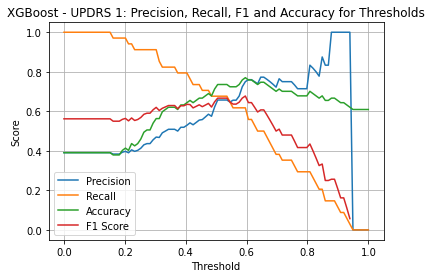

ROC-AUC: 0.7502774694783573 
Accuracy: 0.7241379310344828 
Precision: 0.6388888888888888 
Recall: 0.6764705882352942 
Threshold: 0.5


In [61]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_1_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.5), \
    "\nPrecision:", precision_score(y_test1, preds>0.5), \
    "\nRecall:", recall_score(y_test1, preds>0.5), \
        "\nThreshold: 0.5")

0.8526984126984127 0.7159090909090909 0.5 0.8


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

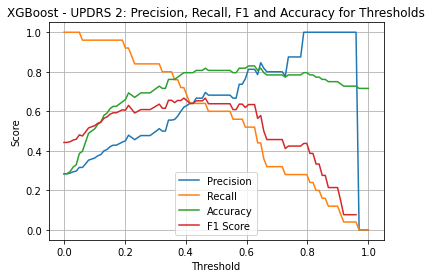

ROC-AUC: 0.8526984126984127 
Accuracy: 0.7159090909090909 
Precision: 0.5 
Recall: 0.8 
Threshold: 0.33


In [62]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_2_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print(roc_auc_score(y_test2, preds), accuracy_score(y_test2, preds>0.33), precision_score(y_test2, preds>0.33), recall_score(y_test2, preds>0.33))

plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.33), \
    "\nPrecision:", precision_score(y_test2, preds>0.33), \
    "\nRecall:", recall_score(y_test2, preds>0.33), \
    "\nThreshold: 0.33")

0.6762971698113207 0.38823529411764707 0.38095238095238093 1.0


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\tit

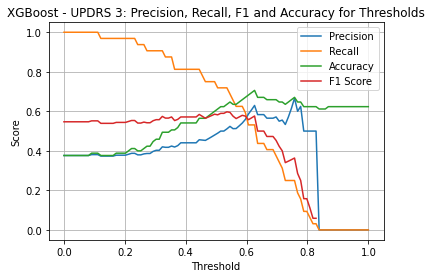

ROC-AUC: 0.6762971698113207 
Accuracy: 0.6235294117647059 
Precision: 0.5 
Recall: 0.71875 
Threshold: 0.52


In [63]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_3_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print(roc_auc_score(y_test3, preds), accuracy_score(y_test3, preds>0.1), precision_score(y_test3, preds>0.1), recall_score(y_test3, preds>0.1))

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'XGBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.52), \
    "\nPrecision:", precision_score(y_test3, preds>0.52), \
    "\nRecall:", recall_score(y_test3, preds>0.52), \
    "\nThreshold: 0.52")


## LGBoost Future Categorical Predictions

In [64]:
lgb_forecast_hyperparams_df.loc['tree_learner'] = lgb_forecast_hyperparams_df.loc['tree_learner'].map({0: 'serial', 1: 'feature', 2: 'data', 3: 'voting'})
lgb_forecast_hyperparams_df.loc['boosting'] = lgb_forecast_hyperparams_df.loc['boosting'].map({0: 'gbdt', 1: 'dart', 2: 'rf'})
# set to false since SMOTE Balanced the classes
lgb_forecast_hyperparams_df.loc['is_unbalance'] = "false"

# convert floats to ints
lgb_forecast_hyperparams_df.loc['max_depth'] = lgb_forecast_hyperparams_df.loc['max_depth'].astype(int)
lgb_forecast_hyperparams_df.loc['max_delta_step'] = lgb_forecast_hyperparams_df.loc['max_delta_step'].astype(int)
lgb_forecast_hyperparams_df.loc['min_data_in_leaf'] = lgb_forecast_hyperparams_df.loc['min_data_in_leaf'].astype(int)
lgb_forecast_hyperparams_df.loc['bagging_freq'] = lgb_forecast_hyperparams_df.loc['bagging_freq'].astype(int)

In [65]:
def train_lgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/lgboost_{updrs}_model_hyperopt_smote_meds.sav'
    # Save the model using pickle
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

    return model

In [66]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_lgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7368717905579903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368717905579903
[LightGBM] [Warning] lambda_l1 is set=4.924832507056549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924832507056549
[LightGBM] [Warning] lambda_l2 is set=7.728146819576027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.728146819576027
[LightGBM] [Warning] bagging_fraction is set=0.7662481474372647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662481474372647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

In [67]:
lgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = prepare_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    lgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2298336711105133, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'bagging_fraction': 0.7662481474372647, 'bagging_freq': 4, 'boosting': 'dart', 'feature_fraction': 0.7368717905579903, 'is_unbalance': 'false', 'lambda_l1': 4.924832507056549, 'lambda_l2': 7.728146819576027, 'max_delta_step': 1, 'min_data_in_leaf': 20, 'tree_learner': 'feature'}


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature

In [68]:
lgb_forecast_results

{'updrs_1': {'auc': 0.7374211819336753,
  'acc': 0.7344245512418413,
  'prec': 0.7611769763337708,
  'recall': 0.6802345938375349},
 'updrs_2': {'auc': 0.8082973095556794,
  'acc': 0.8070099296286152,
  'prec': 0.8278468281294737,
  'recall': 0.7675199800199801},
 'updrs_3': {'auc': 0.7253349156277075,
  'acc': 0.7262869411931674,
  'prec': 0.7763395224660365,
  'recall': 0.6482159700326084}}

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7368717905579903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368717905579903
[LightGBM] [Warning] lambda_l1 is set=4.924832507056549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924832507056549
[LightGBM] [Warning] lambda_l2 is set=7.728146819576027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.728146819576027
[LightGBM] [Warning] bagging_fraction is set=0.7662481474372647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662481474372647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

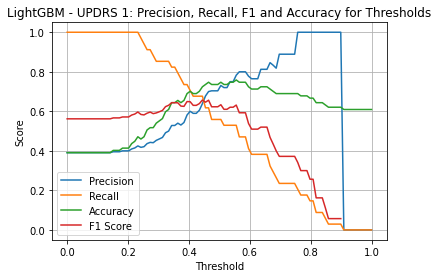

ROC-AUC: 0.7680355160932297 
Accuracy: 0.6436781609195402 
Precision: 0.5283018867924528 
Recall: 0.8235294117647058 
Threshold: 0.35


In [69]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_1_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print(roc_auc_score(y_test1, preds), accuracy_score(y_test1, preds>0.25), precision_score(y_test1, preds>0.25), recall_score(y_test1, preds>0.25))

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.35), \
    "\nPrecision:", precision_score(y_test1, preds>0.35), \
    "\nRecall:", recall_score(y_test1, preds>0.35), \
    "\nThreshold: 0.35")

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.820174975427512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.820174975427512
[LightGBM] [Warning] lambda_l1 is set=1.726209961845676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.726209961845676
[LightGBM] [Warning] lambda_l2 is set=9.968733070887914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.968733070887914
[LightGBM] [Warning] bagging_fraction is set=0.3069356024569016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3069356024569016
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

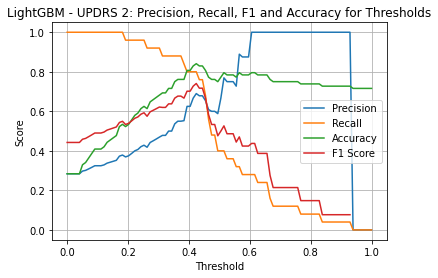

ROC-AUC: 0.8558730158730159 
Accuracy: 0.8295454545454546 
Precision: 0.6666666666666666 
Recall: 0.8 
Threshold: 0.42


In [70]:

# Load the saved model
model = joblib.load('../models/lgboost_updrs_2_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.42), \
    "\nPrecision:", precision_score(y_test2, preds>0.42), \
    "\nRecall:", recall_score(y_test2, preds>0.42), \
    "\nThreshold: 0.42")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.696854884433846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696854884433846
[LightGBM] [Warning] lambda_l1 is set=1.3357567971782522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3357567971782522
[LightGBM] [Warning] lambda_l2 is set=9.155461845313472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.155461845313472
[LightGBM] [Warning] bagging_fraction is set=0.8206721374654345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206721374654345
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

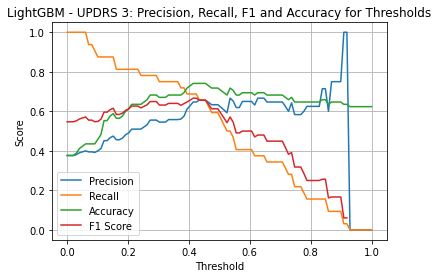

ROC-AUC: 0.7287735849056605 
Accuracy: 0.6823529411764706 
Precision: 0.5555555555555556 
Recall: 0.78125 
Threshold: 0.28


In [71]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_3_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'LightGBM')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.28), \
    "\nPrecision:", precision_score(y_test3, preds>0.28), \
    "\nRecall:", recall_score(y_test3, preds>0.28), \
    "\nThreshold: 0.28")

## Compare Catboost Model

In [31]:
def train_catboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/catboost_{updrs}_model_hyperopt_smote_meds.sav'
    joblib.dump(model, filename)

    return model

In [32]:
cgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    cgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'learning_rate': 0.3667810794764569, 'depth': 7, 'l2_leaf_reg': 5.641366638454, 'bagging_temperature': 4.429427339938372, 'random_state': 42, 'min_data_in_leaf': 8.0}


0:	learn: 0.5869887	total: 711ms	remaining: 11m 50s
1:	learn: 0.4932999	total: 1.13s	remaining: 9m 23s
2:	learn: 0.4138447	total: 1.55s	remaining: 8m 36s
3:	learn: 0.3649467	total: 1.95s	remaining: 8m 6s
4:	learn: 0.3171281	total: 2.39s	remaining: 7m 55s
5:	learn: 0.2810232	total: 2.78s	remaining: 7m 40s
6:	learn: 0.2584536	total: 3.17s	remaining: 7m 30s
7:	learn: 0.2202465	total: 3.55s	remaining: 7m 20s
8:	learn: 0.1964789	total: 3.95s	remaining: 7m 15s
9:	learn: 0.1798746	total: 4.36s	remaining: 7m 11s
10:	learn: 0.1646314	total: 4.79s	remaining: 7m 10s
11:	learn: 0.1499431	total: 5.26s	remaining: 7m 13s
12:	learn: 0.1338643	total: 5.72s	remaining: 7m 14s
13:	learn: 0.1236967	total: 6.07s	remaining: 7m 7s
14:	learn: 0.1163681	total: 6.42s	remaining: 7m 1s
15:	learn: 0.1089789	total: 6.

In [33]:
cgb_forecast_results

{'updrs_1': {'auc': 0.7414697810253631,
  'acc': 0.7413311040210355,
  'prec': 0.7681100217864925,
  'recall': 0.6851202981192477},
 'updrs_2': {'auc': 0.8248872481324572,
  'acc': 0.8215767191251685,
  'prec': 0.8164685621862237,
  'recall': 0.8288794538794539},
 'updrs_3': {'auc': 0.6744949700451202,
  'acc': 0.6718628046886088,
  'prec': 0.6755149090675406,
  'recall': 0.6676813000242541}}

In [30]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_catboost_model(cboost_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_catboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

0:	learn: 0.5713283	total: 1.25s	remaining: 20m 47s
1:	learn: 0.5040508	total: 1.93s	remaining: 16m 5s
2:	learn: 0.4255715	total: 2.54s	remaining: 14m 4s
3:	learn: 0.3700142	total: 3.2s	remaining: 13m 16s
4:	learn: 0.3224636	total: 4.04s	remaining: 13m 23s
5:	learn: 0.2915327	total: 4.99s	remaining: 13m 46s
6:	learn: 0.2603206	total: 5.88s	remaining: 13m 53s
7:	learn: 0.2309120	total: 6.59s	remaining: 13m 37s
8:	learn: 0.2098545	total: 7.22s	remaining: 13m 15s
9:	learn: 0.1923490	total: 8s	remaining: 13m 11s
10:	learn: 0.1796145	total: 8.78s	remaining: 13m 9s
11:	learn: 0.1673270	total: 9.64s	remaining: 13m 13s
12:	learn: 0.1541829	total: 10.2s	remaining: 12m 57s
13:	learn: 0.1406825	total: 10.9s	remaining: 12m 44s
14:	learn: 0.1267027	total: 11.5s	remaining: 12m 34s
15:	learn: 0.1137751	total: 12.1s	remaining: 12m 21s
16:	learn: 0.1018605	total: 13s	remaining: 12m 29s
17:	learn: 0.0945440	total: 14s	remaining: 12m 44s
18:	learn: 0.0862082	total: 14.9s	remaining: 12m 50s
19:	learn: 0.0

KeyboardInterrupt: 

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


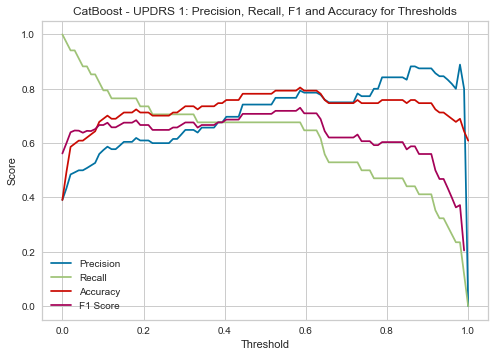

ROC-AUC: 0.8013318534961154 
Accuracy: 0.7241379310344828 
Precision: 0.6190476190476191 
Recall: 0.7647058823529411 
Threshold: 0.18


In [62]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_1_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]


plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test1, preds),\
    "\nAccuracy:", accuracy_score(y_test1, preds>0.18), \
    "\nPrecision:", precision_score(y_test1, preds>0.18), \
    "\nRecall:", recall_score(y_test1, preds>0.18), \
    "\nThreshold: 0.18")

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


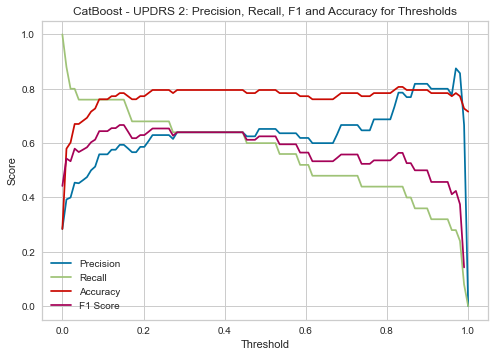

ROC-AUC: 0.7949206349206349 
Accuracy: 0.7840909090909091 
Precision: 0.59375 
Recall: 0.76 
Threshold: 0.14


In [63]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_2_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]


plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test2, preds),\
    "\nAccuracy:", accuracy_score(y_test2, preds>0.14), \
    "\nPrecision:", precision_score(y_test2, preds>0.14), \
    "\nRecall:", recall_score(y_test2, preds>0.14), \
    "\nThreshold: 0.14")

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


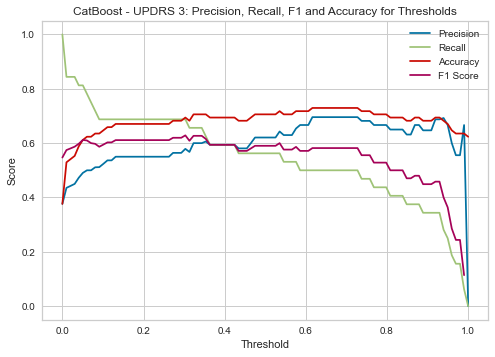

ROC-AUC: 0.7004716981132075 
Accuracy: 0.6823529411764706 
Precision: 0.5641025641025641 
Recall: 0.6875 
Threshold: 0.3


In [64]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_3_model_hyperopt_smote_meds.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]


plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'CatBoost')

print("ROC-AUC:", roc_auc_score(y_test3, preds),\
    "\nAccuracy:", accuracy_score(y_test3, preds>0.3), \
    "\nPrecision:", precision_score(y_test3, preds>0.3), \
    "\nRecall:", recall_score(y_test3, preds>0.3), \
    "\nThreshold: 0.3")

## Compare to Logistic Regression Model

## Forecast Max UPDRS with the SMOTE and meds using Logistic Regression

In [52]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_yr_df_smote, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_yr_df_smote, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_yr_df_smote, model, 'updrs_3')

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [53]:
updrs1_results

(0.5925138581360025,
 0.5951751352705184,
 0.5975815850815851,
 0.5366233993597439)

In [54]:
updrs2_results

(0.6430210038556841,
 0.6412334986053737,
 0.6311419710594832,
 0.6736430236430235)

In [55]:
updrs3_results

(0.5702508290076204, 0.5700013835607596, 0.569150641025641, 0.5274732530250357)

## Max Forecast with Logistic Regression without SMOTE

In [56]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [57]:
updrs1_forecast_results

(0.5402121490678914,
 0.5748580721466587,
 0.45269886363636364,
 0.3682046312860266)

In [58]:
updrs2_forecast_results

(0.5793999108621071,
 0.6721637737262738,
 0.4710243030214567,
 0.3312276491624318)

In [59]:
updrs3_forecast_results

(0.5820521202226789,
 0.6211670838548186,
 0.5179961337856075,
 0.4025927444148391)